<a href="https://colab.research.google.com/github/garg004/Azure-Webpage/blob/main/Retail_Sales_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")


In [17]:
# Load Dataset
df = pd.read_csv("train.csv")

In [18]:
df.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [20]:
# Data Cleaning
# Convert date columns to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True, errors='coerce')


In [21]:
df.fillna(0, inplace=True)

In [22]:
df.drop_duplicates(inplace=True)

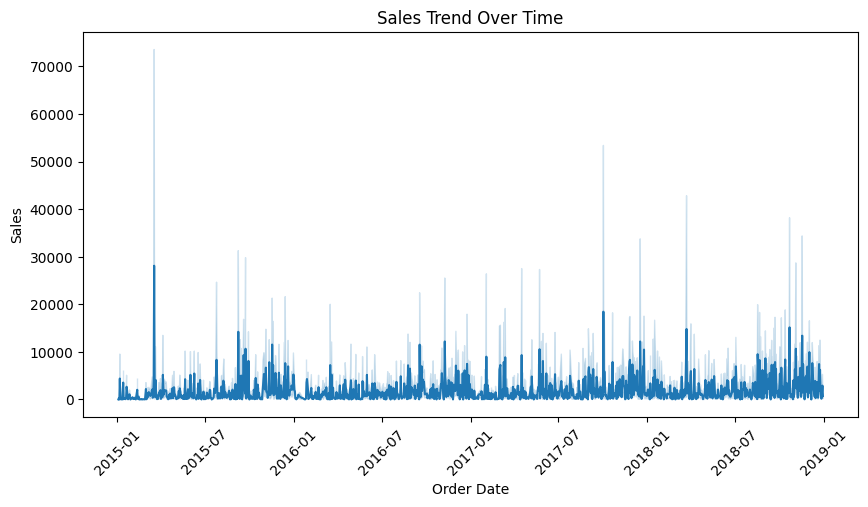

In [23]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='Order Date', y='Sales', estimator='sum')
plt.title('Sales Trend Over Time')
plt.xticks(rotation=45)
plt.show()

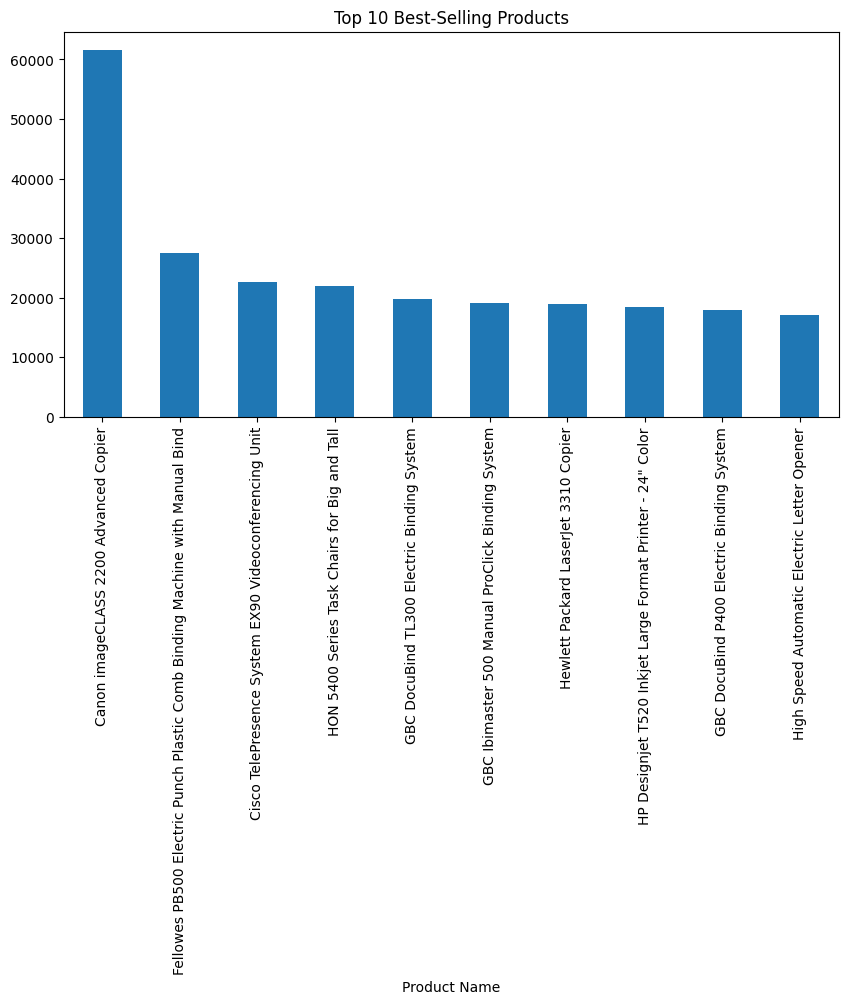

In [24]:
# Top-Selling Products
top_products = df.groupby('Product Name')['Sales'].sum().nlargest(10)
top_products.plot(kind='bar', figsize=(10,5), title='Top 10 Best-Selling Products')
plt.show()

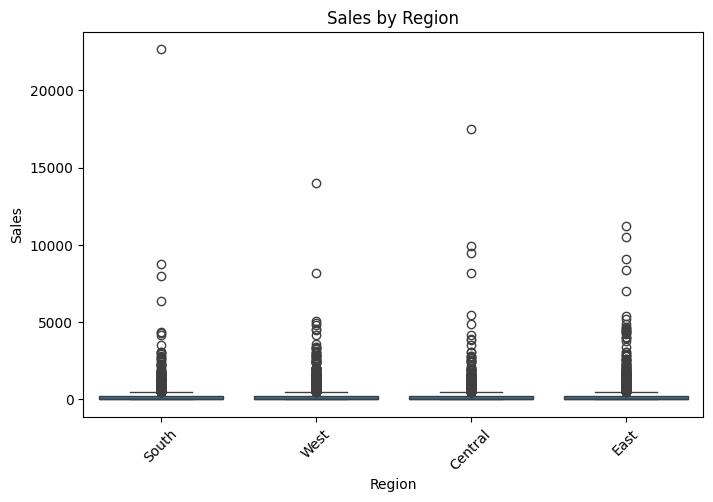

In [25]:
# Sales Analysis by Region
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Region', y='Sales')
plt.title('Sales by Region')
plt.xticks(rotation=45)
plt.show()

In [26]:
# Statistical Summary
print("Statistical Summary of Sales:")
print(df['Sales'].describe())


Statistical Summary of Sales:
count     9800.000000
mean       230.769059
std        626.651875
min          0.444000
25%         17.248000
50%         54.490000
75%        210.605000
max      22638.480000
Name: Sales, dtype: float64


In [27]:
# SQL Integration
conn = sqlite3.connect("sales_data.db")
df.to_sql("sales", conn, if_exists='replace', index=False)

9800

In [28]:
query = """
SELECT Region, SUM(Sales) as Total_Sales
FROM sales
GROUP BY Region
ORDER BY Total_Sales DESC
"""
region_sales = pd.read_sql(query, conn)
print(region_sales)

    Region  Total_Sales
0     West  710219.6845
1     East  669518.7260
2  Central  492646.9132
3    South  389151.4590


In [29]:
# Additional SQL Query: Average Order Value per Region
query_avg = """
SELECT Region, AVG(Sales) as Avg_Order_Value
FROM sales
GROUP BY Region
ORDER BY Avg_Order_Value DESC
"""
avg_order_value = pd.read_sql(query_avg, conn)
print(avg_order_value)

    Region  Avg_Order_Value
0    South       243.524067
1     East       240.401697
2     West       226.184613
3  Central       216.357889


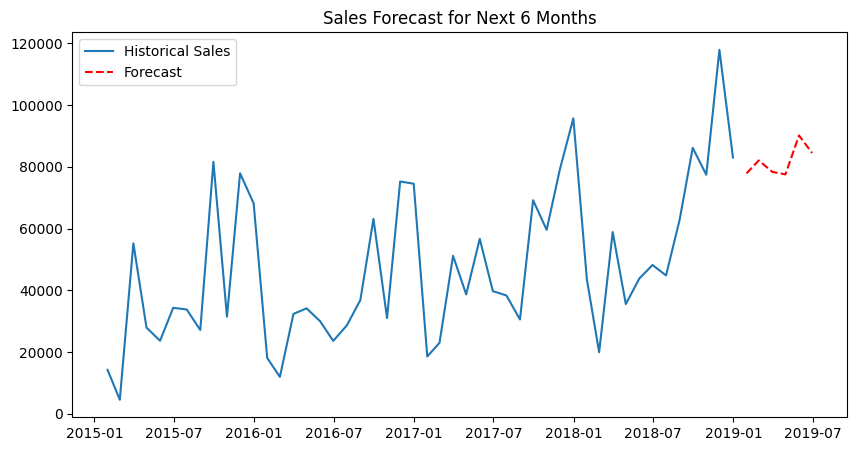

In [30]:
# Time Series Forecasting (ARIMA)
df.set_index('Order Date', inplace=True)
df_resampled = df.resample('M').sum()

model = ARIMA(df_resampled['Sales'], order=(5,1,0))
model_fit = model.fit()
forecast = model_fit.forecast(steps=6)

plt.figure(figsize=(10,5))
plt.plot(df_resampled.index, df_resampled['Sales'], label='Historical Sales')
plt.plot(pd.date_range(df_resampled.index[-1], periods=7, freq='M')[1:], forecast, label='Forecast', linestyle='dashed', color='red')
plt.title('Sales Forecast for Next 6 Months')
plt.legend()
plt.show()
